# Second exercise (Chapter 6 & 8)

In this exercise we consider Chapters 6 & 8 of the book "Deep Learning". The exercise focuses on implementing a small feedforward neural network and training it on the MNIST dataset.

We provide code for structure and utility, you have to **fill in the TODO-gaps**.
It might initially look like a lot of unnecessary code, but it keeps the network extensible. In the following exercises you can reuse what you've done here. Most common neural network libraries (*pytorch*, *tensorflow/keras*, …) are similarly structured, hence they will be easy to use once you've finished this notebook. As we will be using *pytorch* towards the end of the lecture, our API resembles the API of the pytorch framework.


We will implement two different cost functions and play a bit with the value of the different hyperparameters to see how performances change as a function of those. In particular, we will focus on

* Sigmoid Neurons
* Stochastic Gradient Descent
* Quadratic Cost Function
* Cross Entropy Cost Function
* Learning Rate
* Generalization

Note that we'll implement all of these operations to operate on mini-batches of data.

In [1]:
# Some imports used in the code below

from typing import Iterable, List, Optional, Tuple  # type annotations
import pickle  # data loading
import gzip  # data loading

import numpy as np  # linear algebra
import matplotlib.pyplot as plt  # plotting
import scipy.optimize  # gradient check

The cell below contains the two main classes to structure your network. 

**Parameter** is used to represent trainable variables in the network, e.g., a layer's weights $w$. The weights themself are a *numpy array* as the parameter's `data` attribute. The associated parameter gradient (e.g. $\frac{\partial L}{\partial w}$) can be stored in the `grad` attribute.



**Module** is the base class for all parts of the network (activations, layers, …) and even the network itself. They all have to implement the `forward` and `backward` methods. For backpropagation activation will flow *forward* and gradient will flow *backward* through the *network graph and it's modules*. 

Additional module provides utility to check the correctness of implementation by approximating *backward* with [finite difference approximations](https://en.wikipedia.org/wiki/Finite_difference#Relation_with_derivatives)  of *forward*.

*Note:* All modules operate on batches of samples. E.g. the input shape of `Linear.forward` is `(batch_size, feature_shape, 1)` (we will use the last dimension in future exercises).

In [2]:
class Parameter:
    """A trainable parameter.

    This class not only stores the value of the parameter (self.data) but also tensors/
    properties associated with it, such as the gradient (self.grad) of the current backward
    pass.
    """

    def __init__(self, data: np.ndarray, grad: Optional[np.ndarray] = None, name=None):
        self.data = data  # type: np.ndarray
        self.grad = grad  # type: Optional[np.ndarray]
        self.name = name  # type: Optional[str]
        self.state_dict = dict()  # dict to store additional, optional information
        
        
class Module:
    """The base class all network modules must inherit from."""

    def __init__(self):
        # Cache of the input of the forward pass.
        # We need it during the backward pass in most layers,
        #  e.g., to compute the gradient w.r.t to the weights.
        self.input_cache = None

    def __call__(self, *args) -> np.ndarray:
        """Alias for forward, convenience function."""
        return self.forward(*args)

    def forward(self, *args) -> np.ndarray:
        """Compute the forward pass through the module.

        Args:
           args: The inputs, e.g., the output of the previous layer.
        """
        raise NotImplementedError

    def backward(self, grad: np.ndarray) -> np.ndarray:
        """Compute the backward pass through the module.

        This method computes the gradients with respect to the trainable
        parameters and with respect to the first input.
        If the module has trainable parameters, this method needs to update
        the respective parameter.grad property.

        Args:
            grad: The gradient of the following layer.

        Returns:
            The gradient with respect to the first input argument. In general
            it might be useful to return the gradients w.r.t. to all inputs, we
            omit this here to keep things simple.
        """
        raise NotImplementedError

    def parameters(self) -> List[Parameter]:
        """Return the module parameters."""
        return []  # default to empty list

    def check_gradients(self, input_args: Tuple[np.ndarray]):
        """Verify the implementation of the gradients.

        This includes the gradient with respect to the input as well as the
        gradients w.r.t. the parameters if the module contains any.

        As the scipy grad check only works on scalar functions, we compute
        the sum over the output to obtain a scalar.
        """
        assert isinstance(input_args, tuple), (
            "input_args must be a tuple but is {}".format(type(input_args)))
        TOLERANCE = 1e-6
        self.check_gradients_wrt_input(input_args, TOLERANCE)
        self.check_gradients_wrt_params(input_args, TOLERANCE)

    def _zero_grad(self):
        """(Re-) intialize the param's grads to 0. Helper for grad checking."""
        for p in self.parameters():
            p.grad = np.zeros_like(p.data)

    def check_gradients_wrt_input(self, input_args: Tuple[np.ndarray],
                                  tolerance: float):
        """Verify the implementation of the module's gradient w.r.t. input."""

        def output_given_input(x: np.ndarray):
            """Wrap self.forward for scipy.optimize.check_grad."""
            # we only compute the gradient w.r.t. to the first input arg.
            args = (x.reshape(input_args[0].shape),) + input_args[1:]
            return np.sum(self.forward(*args))

        def grad_given_input(x: np.ndarray):
            """Wrap self.backward for scipy.optimize.check_grad."""
            self._zero_grad()
            # run self.forward to store the new input
            args = (x.reshape(input_args[0].shape),) + input_args[1:]
            out = self.forward(*args)
            # compute the gradient w.r.t. to the input
            return np.ravel(self.backward(np.ones_like(out)))

        error = scipy.optimize.check_grad(
            output_given_input, grad_given_input, np.ravel(input_args[0]))
        num_outputs = np.prod(self.forward(*input_args).shape)
        if np.squeeze(error) / num_outputs > tolerance:
            raise RuntimeError("Check of gradient w.r.t. to input for {} failed."
                               "Error {:.4E} > {:.4E}."
                               .format(self, np.squeeze(error), tolerance))

    def check_gradients_wrt_params(self, input_args: Tuple[np.ndarray],
                                   tolerance: float):
        """Verify the implementation of the module's gradient w.r.t. params."""
        for param in self.parameters():
            def output_given_params(new_param: np.ndarray):
                """Wrap self.forward, change the parameters to new_param."""
                param.data = new_param.reshape(param.data.shape)
                return np.sum(self.forward(*input_args))

            def grad_given_params(new_param: np.ndarray):
                self._zero_grad()
                param.data = new_param.reshape(param.data.shape)
                out = self.forward(*input_args)
                # compute the gradient w.r.t. to param
                self.backward(np.ones_like(out))
                return np.ravel(param.grad)
            # flatten the param as scipy can only handle 1D params
            param_init = np.ravel(np.copy(param.data))
            error = scipy.optimize.check_grad(output_given_params,
                                              grad_given_params,
                                              param_init)
            num_outputs = np.prod(self.forward(*input_args).shape)
            if np.squeeze(error) / num_outputs > tolerance:
                raise RuntimeError("Check of gradient w.r.t. to param '{}' for"
                                   "{} failed. Error {:.4E} > {:.4E}."
                                   .format(param.name, self, error, tolerance))

# Nonlinearities

## Sigmoid 

Implement your first network module: The sigmoid activation function.

Verify your sigmoid function by plotting.

In [3]:
class Sigmoid(Module):
    def _sigmoid(self, z: np.ndarray) -> np.ndarray:
        return 1.0/(1.0+np.exp(-z))
        
    def forward(self, z: np.ndarray) -> np.ndarray:
        assert len(z.shape) == 3, ("z.shape should be (batch_size, input_size, 1)"
                                   " but is {}.".format(z.shape))
        h = self._sigmoid(z)
        # here it's useful to store the activation 
        #  instead of the input
        self.input_cache = h
        return h

    def backward(self, grad: np.ndarray) -> np.ndarray:
        h = self.input_cache
        
        sigmoid_d = h*(1-h)
        #o = np.dot(grad,sigmoid_d)
        #print(grad.shape)
        o = grad * sigmoid_d
        return o
        

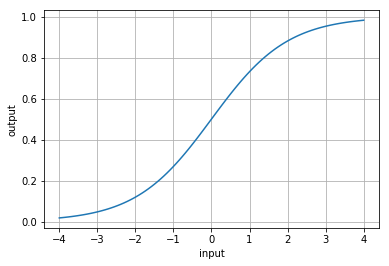

In [4]:
x = np.linspace(-4, +4, 100)
sigmoid = Sigmoid()

y = np.ravel(sigmoid(x.reshape(-1, 1, 1)))
# equal to call of sigmoid.forward(x)
plt.plot(x,y)
plt.xlabel('input')
plt.ylabel('output')
plt.grid(True)
plt.show()

## Relu

Implement Relu and plot for verification

In [5]:
class Relu(Module):
    
    def forward(self, z: np.ndarray) -> np.ndarray:
        self.input_cache = z
        return np.maximum(0.0, z)
 
    def backward(self, grad: np.ndarray) -> np.ndarray:
        z = self.input_cache
        return (z>=0) * grad
        #raise NotImplementedError
        

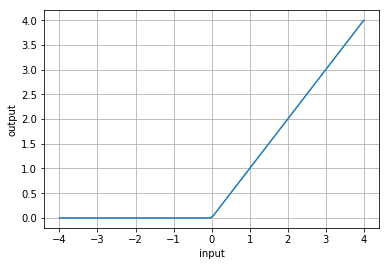

In [6]:
x = np.linspace(-4, +4, 100)
relu = Relu()

y = np.ravel(relu(x.reshape(-1,1,1)))
#print (y)
plt.plot(x,y)
plt.xlabel('input')
plt.ylabel('output')
plt.grid(True)
plt.show()

## Softmax

Implement the numerical stable softmax. We will not need the backward pass. 

In [7]:
class Softmax(Module):
    def _softmax(self, z):
        # don't reduce (sum) over batch axis
        reduction_axes = tuple(range(1, len(z.shape))) 
        x_max = np.max(z, axis=reduction_axes, keepdims=True)
        x_safe = z - x_max
        e_x = np.exp(x_safe)
        return e_x / np.sum(e_x, axis=reduction_axes, keepdims=True)
        # START TODO ################
        
        # Shift input for numerical stability.
        # END TODO###################
        #return h
    
    def forward(self, z: np.ndarray) -> np.ndarray:
        h = self._softmax(z)
        return h

    def backward(self, grad) -> np.ndarray:
        error_msg = ("Softmax doesn't need to implement a gradient here, as it's"
                     "only needed in CrossEntropyLoss, where we can simplify"
                     "the gradient for the combined expression.")
        raise NotImplementedError(error_msg)


In [8]:
# Check your softmax
softmax = Softmax()
x = np.array([1.0, 2.0, 3.0, 4.0, 1.0, 2.0, 3.0]).reshape(1, -1, 1)

# Testcase from https://en.wikipedia.org/wiki/Softmax_function#Example
np.testing.assert_allclose(
    np.ravel(softmax(x)), 
    [0.02364054, 0.06426166, 0.1746813, 0.474833, 0.02364054, 0.06426166, 0.1746813],
    rtol=1e-5, err_msg="Softmax is not correct implemented")


# Linear Layer

Implement a linear (in other frameworks also called dense or fully connected) network layer. 
Here you also have to use the Parameter class.

In [9]:
class Linear(Module):

    def __init__(self, in_features: int, out_features: int):
        super().__init__()
        
        w_data = 0.01 * np.random.randn(out_features, in_features)
        self.W = Parameter(w_data, "W")
        
        b_data = 0.01 * np.ones((out_features, 1))
        self.b = Parameter(b_data, "b")

    def forward(self, x: np.ndarray) -> np.ndarray:
        assert len(x.shape) == 3, ("x.shape should be (batch_size, input_size, 1)"
                                   " but is {}.".format(x.shape))
        self.input_cache = x
    
       
        return np.matmul(self.W.data,x) + self.b.data
      

    def backward(self, grad: np.ndarray) -> np.ndarray:
        x = self.input_cache
        # remember that input has a batch dimension when transposing, i.e.,
        # we need to use np.transpose instead of x.T
        x_transpose = np.transpose(x, [0, 2, 1])
        
       
        
        # START TODO ################ 
        self.W.grad=np.matmul(grad,x_transpose).sum(axis=0)
        self.b.grad=grad  
        # ...
        # raise NotImplementedError
        return np.matmul(self.W.data.T,grad)
      
        
      
      
    def parameters(self) -> List[Parameter]:
        return [self.W,]
      

# Cost Functions



In [10]:
# Define the Cross-Entropy cost function

class CrossEntropyLoss(Module):
    """Compute the cross entropy."""

    def __init__(self):
        super().__init__()
        self.softmax = Softmax()

    def forward(self, a: np.ndarray, y: np.ndarray) -> np.ndarray:
        """Compute the cross entropy, mean over batch size."""
        a = self.softmax(a)
        self.input_cache = a, y
        # compute the mean over the batch
        return -np.sum(np.log(a[y == 1])) / len(a)

    def backward(self, _=None) -> np.ndarray:
        # we introduce the argument _ here, to have a unified interface with
        # other Module objects. This simplifies code for gradient checking. 
        # We don't need this arg.
        a, y = self.input_cache
        
        
        grad = (a-y)/y.shape[0] 
        grad.resize(grad.shape[0],grad.shape[1],1)
      
        assert len(grad.shape) == 3, ("CrossEntropyLoss.backward should return (batch_size, grad_size, 1)"
                                      " but is {}.".format(grad.shape))
        return grad


class MSELoss(Module):
    """Compute the mean squared error loss."""

    def forward(self, a: np.ndarray, y: np.ndarray) -> np.ndarray:
        self.input_cache = a, y
        return np.sum(0.5 * np.linalg.norm(a - y, axis=-1)**2) / len(a)

    def backward(self, _=None):
        # we introduce the argument _ here, to have a unified interface with
        # other Module objects. This simplifies code for gradient checking. 
        # We don't need this arg
        a, y = self.input_cache
        
        grad = (a - y)/y.shape[0] 
        grad.resize(grad.shape[0],grad.shape[1],1)
        #print(grad.shape)
        # Recreate the batch dimension
        
        
        assert len(grad.shape) == 3, ("MSELossCrossEntropyLoss.backward should return (batch_size, grad_size, 1)"
                                      " but is {}.".format(grad.shape))
        return grad

# Sequential Network

In [11]:
class Sequential(Module):
    """A sequential container to stack modules.

    Modules will be added to it in the order they are passed to the
    constructor.

    Example network with one hidden layer:
    model = Sequential(
                  Linear(5,10),
                  ReLU(),
                  Linear(10,10),
                )
    """
    def __init__(self, *args: List[Module]):
        super().__init__()
        self.modules = args

    def forward(self, x: np.ndarray) -> np.ndarray:
        # START TODO ################ 
        for module in self.modules:
            x = module.forward(x)
        #raise NotImplementedError
        # Remember: module(x) is equivalent to module.forward(x)
        # END TODO ##################
        return x

    def backward(self, grad: np.ndarray) -> np.ndarray:
        # START TODO ################ 
        #raise NotImplementedError
        for module in reversed(self.modules):
            grad = module.backward(grad)
        # END TODO ##################
        return grad

    def parameters(self) -> List[Parameter]:
        # iterate over modules and retrieve their parameters, iterate over
        # parameters to flatten the list
        return [param for module in self.modules
                for param in module.parameters()]
      
      

# One hot encoding
To handle categorical data, we need to implement the one_hot_encoding utility function.

In [12]:
def one_hot_encoding(y: np.ndarray, num_classes: int) -> np.ndarray:
    """Convert integer labels to one hot encoding.

    Example: y=[1, 2] --> [[0, 1, 0], [0, 0, 1]]
    """
    classes = np.unique(y)
    encoded = np.zeros(y.shape + (num_classes,))
    for c in classes:
        encoded[y == c, c] = 1
    return encoded


y = np.array([1, 2, 0])
np.testing.assert_equal(one_hot_encoding(y, 3), [[0, 1, 0], [0, 0, 1], [1, 0, 0]]) 

# Gradient Check

Gradient checking is a useful utility to check, whether forward and backward pass are matching. 
Backward passes are approximated by finite differences of the forward pass.
We have implemented the gradient checking in the Module class for you. As all classes we defined up to here inherit from Module, we can run `check_gradients`.

In [13]:
input_vector = np.random.uniform(-1., 1., size=(2, 10, 1))
input_args = (input_vector,)

# layers + activations
Relu().check_gradients(input_args)
Sigmoid().check_gradients(input_args)
Linear(10, 30).check_gradients(input_args)
Linear(10, 10).check_gradients(input_args)
# MLP
# START TODO ################ 

model = Sequential(
                  Linear(10,10),
                  Sigmoid(),
                  Linear(10,30),
                  Sigmoid()
)

model.check_gradients(input_args)
#raise NotImplementedError


# gradient check a Sequential network with 
# layers: linear, sigmoid, linear, sigmoid
# END TODO ##################

# losses


input_args_losses = (one_hot_encoding(np.array([1, 2]), 3),  # a
                     one_hot_encoding(np.array([1, 1]), 3))  # y (ground truth)
MSELoss().check_gradients(input_args_losses)
CrossEntropyLoss().check_gradients(input_args_losses)


# Optimizers

Below you see the base class for all optimizers. An Optimizer needs to implement the `step()` function, which updates the parameters passed to the constructor.

In [14]:
class Optimizer:
    """The base class for optimizers.

    All optimizers must implement a step() method that updates the parameters.
    The general optimization loop then looks like this:

    for inputs, targets in dataset:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()

    `zero_grad` initializes the gradients of the parameters to zero. This
    allows to accumulate gradients (instead of replacing it) during
    backpropagation, which is e.g. useful for skip connections.
    """

    def __init__(self, params: Iterable[Parameter]):
        """
        Args:
            params: The parameters to be optimized.
        """
        self._params = params

    def step(self) -> None:
        """Update the parameters."""
        raise NotImplementedError

    def zero_grad(self) -> None:
        """Clear the gradients of all optimized parameters."""
        for param in self._params:
            assert isinstance(param, Parameter)
            param.grad = np.zeros_like(param.data)

## SGD

Implement stochastic gradient descent (Chapter 5, Chapter 8). 
The momentum parameter improves training speed (Chapter 8.3).

In [15]:
class SGD(Optimizer):
    """Stochastic Gradient Descent (SGD) optimizer with optional Momentum."""

    def __init__(self, params: Iterable[Parameter], lr: float,
                 momentum: Optional[float] = None):
        super().__init__(params)
        self.lr = lr
        self.momentum = momentum
        if momentum:
            for param in self._params:
                param.state_dict["momentum"] = np.zeros_like(param.data)

    def step(self):
        for p in self._params:
            if self.momentum:
                # SGD with Momentum
                # START TODO ################ 
                p.state_dict["momentum"] = self.momentum * p.state_dict.get("momentum")+ self.lr * p.grad
                p.data = p.data - p.state_dict.get("momentum")
                #p.data = p.data - self.lr * p.grad
                # END TODO ##################
            else:
             
                # Standard SGD
                # START TODO ################ 
                #raise NotImplementedError
                # END TODO ##################
                p.data = p.data - self.lr * p.grad


## Data Loading

In [16]:
def load_mnist_data():
    """Loads the data, returns training_data, validation_data, test_data."""
    with gzip.open('mnist.pkl.gz', 'rb') as f:
        return pickle.load(f, encoding='latin1')


def minibatched(data: np.ndarray, batch_size: int) -> List[np.ndarray]:
    assert len(data) % batch_size == 0, ("Data length {} is not multiple of batch size {}"
                                         .format(len(data), batch_size))
    return data.reshape(-1, batch_size, *data.shape[1:])


(x_train, y_train), (x_val, y_val), (x_test, y_test) = load_mnist_data()
x_train = np.expand_dims(x_train, axis=-1)
x_val = np.expand_dims(x_val, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

num_classes = 10
y_train = one_hot_encoding(y_train, num_classes)
y_val = one_hot_encoding(y_val, num_classes)
y_test = one_hot_encoding(y_test, num_classes)

## Training

Implement the actual training loop.

In [17]:
def accuracy(y, predictions, y_is_onehot: bool = False) -> float:
    y_predicted = np.argmax(predictions, axis=-1)
    y = np.argmax(y, axis=-1)
    return np.sum(np.equal(y_predicted, y)) / len(y)


def evaluate(data, labels, model, batch_size):
    predictions = []
    eval_cost = 0.
    data_batched = minibatched(data, batch_size)
    labels_batched = minibatched(labels, batch_size)

    for x, y in zip(data_batched, labels_batched):
        # note that when using cross entropy loss, the softmax is included in the
        # loss and we'd need to apply it manually here to obtain the output as probabilities.
        # However, softmax only rescales the outputs and doesn't change the argmax,
        # so we'll skip this here, as we're only interested in the class prediction.
        h_1 = np.squeeze(model(x))
        predictions.append(h_1)
        eval_cost += loss_fn(h_1, y)
    predictions = np.array(predictions).reshape(-1, 10)
    eval_accuracy = accuracy(y_val, predictions, False)
    return eval_accuracy, eval_cost


def train(model, loss_fn, optimizer, x_train, y_train, x_val, y_val, num_epochs, batch_size):
    train_costs, train_accuracies = np.zeros(num_epochs), np.zeros(num_epochs)
    eval_costs, eval_accuracies = np.zeros(num_epochs), np.zeros(num_epochs)
    ix = np.arange(len(x_train))
    
    for epoch in range(num_epochs):
        print("Epoch {} / {}:".format(epoch + 1, num_epochs))
        training_predictions = []
        
        np.random.shuffle(ix)
        x_train_batched = minibatched(x_train[ix], batch_size)
        y_train_batched = minibatched(y_train[ix], batch_size)
        
        # train for one epoch
        for x_batch, y_batch in zip(x_train_batched, y_train_batched):
            # START TODO ################ 
            optimizer.zero_grad()
            output = np.squeeze(model(x_batch)) #remove an axis as advised
            training_predictions.append(output)
            
            loss = loss_fn(output,y_batch)
            model.backward(loss_fn.backward())
            optimizer.step()
            #raise NotImplementedError
            # TIPP: Look at the optimizer's docstring about how to use it.
            #       You might have to add / remove an axis.
            # END TODO ##################
            train_costs[epoch] += loss
            
       
        training_predictions = np.array(training_predictions).reshape(-1, 10)
        train_accuracies[epoch] = accuracy(y_train[ix], training_predictions, False)
        print("  Training Accuracy: {:.4f}".format(train_accuracies[epoch]))
        print("  Training Cost: {:.4f}".format(train_costs[epoch]))
        eval_accuracies[epoch], eval_costs[epoch] = evaluate(x_val, y_val, model, batch_size)
        print("  Eval Accuracy: {:.4f}".format(eval_accuracies[epoch]))
    return train_costs, train_accuracies, eval_costs, eval_accuracies

** Your feedback on exercise 2.2: ** 

It too long to complete this exercise. It was great to check our implementations after every step, so thank you for giving the "check" codes. But this exercise should have been a 3rd exercise after an easier coding exercise. 10 days was not enough to perfect our python coding skills and apply it here, but we tried our best. It took almost 2 days to complete this part.


# Experiments

Apply it on a sequential model (linear, sigmoid, linear, softmax (included in cross entropy!). Use the cross entropy loss and sgd with momentum. Use the hyperparameters defined below.

What is the best accuracy you can achieve?

**Answer:**

The numerical results and graphs are given below as the output of the code.

Best Accuracies:

Training Accuracy: 0.9766

Validation Accuracy: 0.9656

Epoch 1 / 10:
  Training Accuracy: 0.8500
  Training Cost: 480.0427
  Eval Accuracy: 0.9435
Epoch 2 / 10:
  Training Accuracy: 0.9416
  Training Cost: 197.6817
  Eval Accuracy: 0.9556
Epoch 3 / 10:
  Training Accuracy: 0.9530
  Training Cost: 158.2133
  Eval Accuracy: 0.9598
Epoch 4 / 10:
  Training Accuracy: 0.9607
  Training Cost: 133.6605
  Eval Accuracy: 0.9582
Epoch 5 / 10:
  Training Accuracy: 0.9636
  Training Cost: 119.8321
  Eval Accuracy: 0.9624
Epoch 6 / 10:
  Training Accuracy: 0.9673
  Training Cost: 108.1877
  Eval Accuracy: 0.9634
Epoch 7 / 10:
  Training Accuracy: 0.9699
  Training Cost: 98.5012
  Eval Accuracy: 0.9643
Epoch 8 / 10:
  Training Accuracy: 0.9729
  Training Cost: 89.1304
  Eval Accuracy: 0.9627
Epoch 9 / 10:
  Training Accuracy: 0.9748
  Training Cost: 83.0350
  Eval Accuracy: 0.9643
Epoch 10 / 10:
  Training Accuracy: 0.9760
  Training Cost: 77.8621
  Eval Accuracy: 0.9637


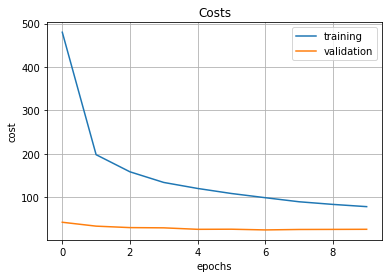

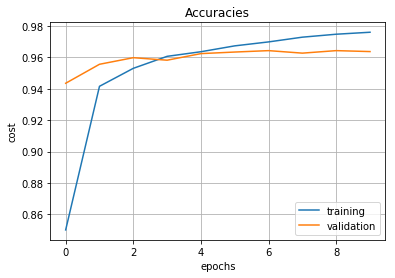

In [18]:
num_epochs = 10
batch_size = 50
learning_rate = 0.1
momentum = 0.9
linear_units = 30
# START TODO ################

#Parameter(b_data, "b")

#input_vector = np.random.uniform(-1., 1., size=(2, 10, 1))
#input_args = (input_vector,)

model = Sequential(
                  Linear(784,30),
                  Sigmoid(),
                  Linear(30,10)
)
loss_fn = CrossEntropyLoss()
optimizer = SGD(model.parameters(),learning_rate,momentum)
#print(x_train.shape)
[train_costs, train_accuracies, eval_costs, eval_accuracies] = train(model, loss_fn, optimizer, x_train, y_train, x_val, y_val, num_epochs, batch_size)


plt.figure(1)
plt.plot(train_costs, label='training')
plt.plot(eval_costs, label='validation')
plt.legend(loc='best')
plt.ylabel('cost')
plt.xlabel('epochs')
plt.title('Costs')
plt.grid(True)

plt.figure(2)
plt.plot(train_accuracies, label='training')
plt.plot(eval_accuracies, label='validation')
plt.legend(loc='best')
plt.ylabel('cost')
plt.xlabel('epochs')
plt.title('Accuracies')
plt.grid(True)

plt.show()

Now run again with the increased learning rate. Which accuracy can you achieve now? How did the accuracies change while training, compared to the lower learning rate?

**Note:** Make sure, to reinitialize your model's parameters. Don't continue on the already trained parameters.

**Answer**

The results for the higher learning rate can be seen after the code is run. As it can be seen from the values and the graphs, even though the cost decreases and accuracy increases after every epoch, the values are still not good. Accuries are too low compared (*Training Accuracy: 0.3867, validation Accuracy: 0.3862*) to the case with lower learning rate (*Training Accuracy: 0.9766, Validation Accuracy: 0.9656*).  Here we see the importance of selecting the optimal learning rate. If the learning rate is higher than optimal, the optimizer cannot converge to the optimal solution of the minimization problem as the steps are too large.

**Note:** The behaviour of the code is highly stochastic because of the high learning rate, so if the results are not matching with the answer given above, please run it again.

Epoch 1 / 10:
  Training Accuracy: 0.2621
  Training Cost: 1756.8945
  Eval Accuracy: 0.2953
Epoch 2 / 10:
  Training Accuracy: 0.3971
  Training Cost: 1433.9864
  Eval Accuracy: 0.6890
Epoch 3 / 10:
  Training Accuracy: 0.7069
  Training Cost: 971.5699
  Eval Accuracy: 0.8269
Epoch 4 / 10:
  Training Accuracy: 0.7907
  Training Cost: 795.6374
  Eval Accuracy: 0.8015
Epoch 5 / 10:


/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()


  Training Accuracy: 0.8233
  Training Cost: 680.2015
  Eval Accuracy: 0.8613
Epoch 6 / 10:
  Training Accuracy: 0.8503
  Training Cost: 592.4921
  Eval Accuracy: 0.8670
Epoch 7 / 10:
  Training Accuracy: 0.8507
  Training Cost: 584.2060
  Eval Accuracy: 0.8730
Epoch 8 / 10:
  Training Accuracy: 0.8613
  Training Cost: 535.4667
  Eval Accuracy: 0.8797
Epoch 9 / 10:
  Training Accuracy: 0.8699
  Training Cost: 501.2534
  Eval Accuracy: 0.8914
Epoch 10 / 10:
  Training Accuracy: 0.8773
  Training Cost: 462.8852
  Eval Accuracy: 0.8928


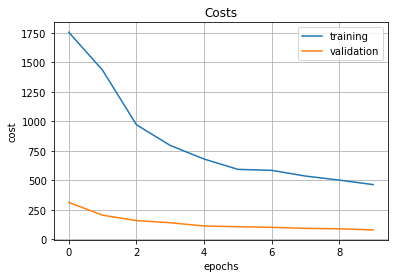

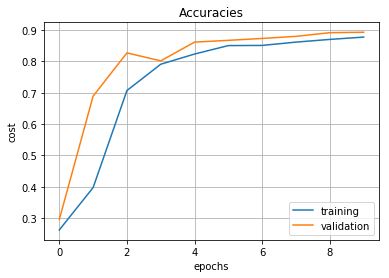

In [19]:
higher_learning_rate = 3
num_epochs = 10
batch_size = 50
momentum = 0.9
linear_units = 30
model = Sequential(
                  Linear(784,30),
                  Sigmoid(),
                  Linear(30,10)
)
loss_fn = CrossEntropyLoss()
optimizer = SGD(model.parameters(),higher_learning_rate,momentum)

[train_costs_3, train_accuracies_3, eval_costs_3, eval_accuracies_3] = train(model, loss_fn, optimizer, x_train, y_train, x_val, y_val, num_epochs, batch_size)

plt.figure(1)
plt.plot(train_costs_3, label='training')
plt.plot(eval_costs_3, label='validation')
plt.legend(loc='best')
plt.ylabel('cost')
plt.xlabel('epochs')
plt.title('Costs')
plt.grid(True)

plt.figure(2)
plt.plot(train_accuracies_3, label='training')
plt.plot(eval_accuracies_3, label='validation')
plt.legend(loc='best')
plt.ylabel('cost')
plt.xlabel('epochs')
plt.title('Accuracies')
plt.grid(True)

plt.show()

Train only a subset of 1000 training samples, but for 300 epochs. 
Plot the costs & accuracies for both training and validation.

How do the accuracies change compared to the previous runs?
How is this plot related to the term 'overfitting'?

**Answer**

We observe that the accuracy for training set is maximum (1.0), however the validation accuracy (0.8580) is less than the first case. Here we see the phenomena called *overfitting*. The traning error decreases after every iteration and is minimized at the end, but the validation error increases and it causes the loss in validation accuracy. Our model becomes biased to traning data, it will perform poorly for test data as well. It is caused since we just had only a small  portion of the data and we trained more than necessary as we chose number of epochs as 300.

In [20]:
num_train_samples = 1000
num_epochs = 300
learning_rate = 0.1
momentum = 0.9
linear_units = 30


print(x_train.shape)
x_train_small = (x_train[0:num_train_samples,:,:])
x_val_small = (x_val[0:num_train_samples,:,:])
x_test_small = (x_test[0:num_train_samples,:,:])
print(x_train_small.shape)
print(x_val_small.shape)
print(x_test_small.shape)
num_classes = 10
print('----')
print(y_train.shape)
y_train = (y_train[0:num_train_samples,:])
y_val = (y_val[0:num_train_samples,:])
y_test = (y_test[0:num_train_samples,:])

# START TODO ################

#Parameter(b_data, "b")

#input_vector = np.random.uniform(-1., 1., size=(2, 10, 1))
#input_args = (input_vector,)

model = Sequential(
                  Linear(784,30),
                  Sigmoid(),
                  Linear(30,10)#,
                  #Softmax()
)
loss_fn = CrossEntropyLoss()
optimizer = SGD(model.parameters(),learning_rate,momentum)

[train_costs_SMALL, train_accuracies_SMALL, eval_costs_SMALL, eval_accuracies_SMALL] = train(model, loss_fn, optimizer, x_train_small, y_train, x_val_small, y_val, num_epochs, batch_size)

(50000, 784, 1)
(1000, 784, 1)
(1000, 784, 1)
(1000, 784, 1)
----
(50000, 10)
Epoch 1 / 300:
  Training Accuracy: 0.0990
  Training Cost: 46.2312
  Eval Accuracy: 0.1040
Epoch 2 / 300:
  Training Accuracy: 0.1350
  Training Cost: 45.5486
  Eval Accuracy: 0.1470
Epoch 3 / 300:
  Training Accuracy: 0.3300
  Training Cost: 39.6540
  Eval Accuracy: 0.4420
Epoch 4 / 300:
  Training Accuracy: 0.5760
  Training Cost: 27.2414
  Eval Accuracy: 0.6420
Epoch 5 / 300:
  Training Accuracy: 0.7550
  Training Cost: 18.3495
  Eval Accuracy: 0.7140
Epoch 6 / 300:
  Training Accuracy: 0.8300
  Training Cost: 13.2577
  Eval Accuracy: 0.7640
Epoch 7 / 300:
  Training Accuracy: 0.8650
  Training Cost: 10.4828
  Eval Accuracy: 0.7960
Epoch 8 / 300:
  Training Accuracy: 0.8800
  Training Cost: 8.6010
  Eval Accuracy: 0.8120
Epoch 9 / 300:
  Training Accuracy: 0.8980
  Training Cost: 7.4095
  Eval Accuracy: 0.8250
Epoch 10 / 300:
  Training Accuracy: 0.9210
  Training Cost: 6.2964
  Eval Accuracy: 0.8310
Epoc

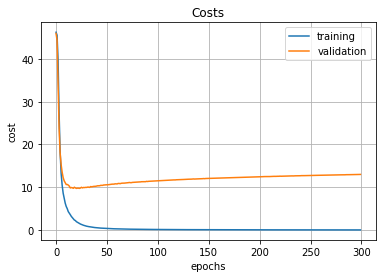

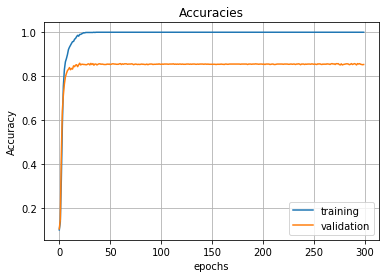

In [21]:
plt.figure(1)
plt.plot(train_costs_SMALL, label='training')
plt.plot(eval_costs_SMALL, label='validation')
plt.legend(loc='best')
plt.ylabel('cost')
plt.xlabel('epochs')
plt.title('Costs')
plt.grid(True)

plt.figure(2)
plt.plot(train_accuracies_SMALL, label='training')
plt.plot(eval_accuracies_SMALL, label='validation')
plt.legend(loc='best')
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.title('Accuracies')
plt.grid(True)

plt.show()

** Your feedback on exercise 2.3: ** 

It was good to see the visiual results and the effects of learning rate, number of epochs and data size on performance. It was a concise but sufficient exercise to understand these effects. It took 5 hours to develop, debug and finalise the code.